

## Problem statement:
Text Recognition in Images: Classify different types of text in images (e.g., handwritten vs. printed text)

[*Had to delete the bulk dataset due to insufficient Google Drive space.*]

Name: Nabila Tajrin Bristy

# 1. INSTALL NECESSARY PACKAGES

In [ ]:
# Install necessary packages
!pip install --user tensorflow opencv-python numpy matplotlib pytesseract Pillow scikit-learn tensorflow-addons==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# 2. IMPORTS

In [ ]:
# --- IMPORTS ---
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from skimage.feature import hog
from skimage import exposure
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt

# 3. MOUNT GOOGLE DRIVE

In [ ]:
# --- MOUNT GOOGLE DRIVE ---
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 4. SET PATHS AND PARAMETERS

In [ ]:
# --- SET PATHS AND PARAMETERS ---
# Define dataset paths
DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/dataset/'

train_handwritten_dir = os.path.join(DATASET_PATH, 'train/handwritten')
train_printed_dir = os.path.join(DATASET_PATH, 'train/printed')
test_handwritten_dir = os.path.join(DATASET_PATH, 'test/handwritten')
test_printed_dir = os.path.join(DATASET_PATH, 'test/printed')

# Image dimensions
img_height, img_width = 180, 180

# 5. LOAD DATASET

In [ ]:
# --- LOAD DATASET ---
def read_image_folder(folder, img_size=(img_height, img_width)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.asarray(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images, dtype='float32') / 255.0  # Normalize pixel values

# Load handwritten and printed images for train and test sets
X_handwritten_train = read_image_folder(train_handwritten_dir)
X_printed_train = read_image_folder(train_printed_dir)
X_handwritten_test = read_image_folder(test_handwritten_dir)
X_printed_test = read_image_folder(test_printed_dir)

# Create labels (0 = Handwritten, 1 = Printed)
y_handwritten_train = np.zeros(X_handwritten_train.shape[0])
y_printed_train = np.ones(X_printed_train.shape[0])
y_handwritten_test = np.zeros(X_handwritten_test.shape[0])
y_printed_test = np.ones(X_printed_test.shape[0])

# Combine train/test data and labels
X_train = np.concatenate((X_handwritten_train, X_printed_train), axis=0)
y_train = np.concatenate((y_handwritten_train, y_printed_train), axis=0)
X_test = np.concatenate((X_handwritten_test, X_printed_test), axis=0)
y_test = np.concatenate((y_handwritten_test, y_printed_test), axis=0)

# Shuffle training and testing data
def shuffle_data(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

X_train, y_train = shuffle_data(X_train, y_train)
X_test, y_test = shuffle_data(X_test, y_test)

# 6. VISUALIZE SAMPLE IMAGES AND DATA DISTRIBUTION

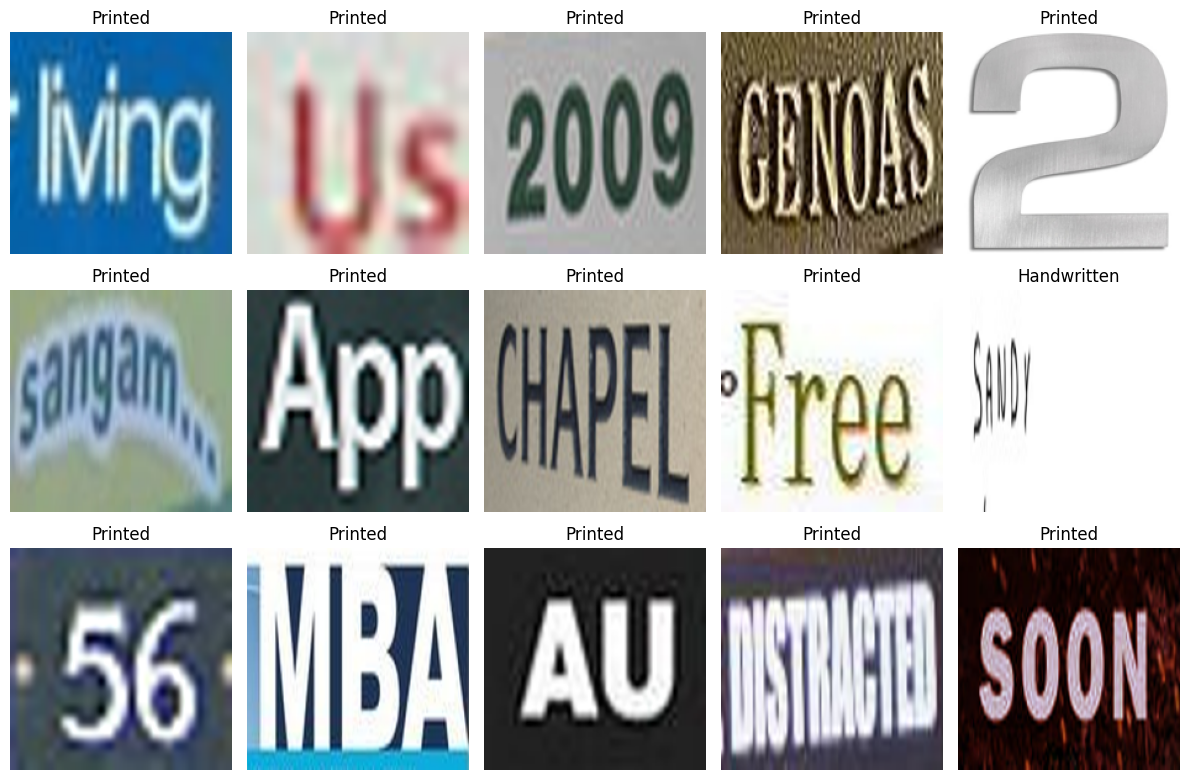

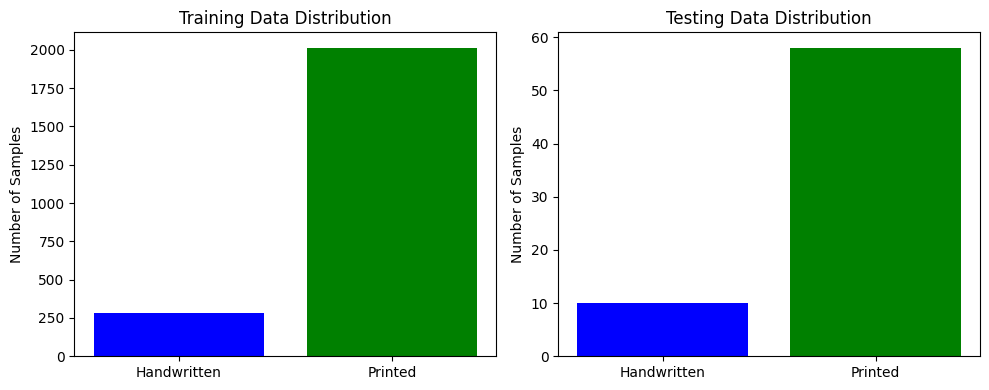

In [ ]:
# --- VISUALIZE DATA ---
def plot_sample_images(X, y, n_samples=15):
    plt.figure(figsize=(12, 8))
    for i in range(n_samples):
        plt.subplot(3, 5, i+1)
        plt.imshow(X[i])
        plt.title('Handwritten' if y[i] == 0 else 'Printed')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_data_distribution(y_train, y_test):
    plt.figure(figsize=(10, 4))

    # Training Data Distribution
    plt.subplot(1, 2, 1)
    plt.bar(['Handwritten', 'Printed'], [np.sum(y_train == 0), np.sum(y_train == 1)], color=['blue', 'green'])
    plt.title('Training Data Distribution')
    plt.ylabel('Number of Samples')

    # Testing Data Distribution
    plt.subplot(1, 2, 2)
    plt.bar(['Handwritten', 'Printed'], [np.sum(y_test == 0), np.sum(y_test == 1)], color=['blue', 'green'])
    plt.title('Testing Data Distribution')
    plt.ylabel('Number of Samples')

    plt.tight_layout()
    plt.show()

# Display sample images and class distributions
plot_sample_images(X_train, y_train)
plot_data_distribution(y_train, y_test)

# 7. FEATURE EXTRACTION USING HOG (Optional but Recommended)

In [ ]:
# --- FEATURE EXTRACTION USING HOG ---
def extract_hog_features(images):
    hog_features = []
    for image in images:
        gray_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        features, hog_image = hog(gray_image,
                                  orientations=9,
                                  pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2),
                                  block_norm='L2-Hys',
                                  visualize=True,
                                  transform_sqrt=True)
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features
print("Extracting HOG features from training data...")
X_train_hog = extract_hog_features(X_train)
print("Extracting HOG features from testing data...")
X_test_hog = extract_hog_features(X_test)
print('Extraction is done')

Extracting HOG features from training data...
Extracting HOG features from testing data...
Extraction is done


# 8. FEATURE SCALING

In [ ]:
# --- FEATURE SCALING ---
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)
print('Scaling is done')

Scaling is done


# 9. ENCODE LABELS

In [ ]:
# --- LABEL ENCODING ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
print('Encoding is done')

Encoding is done


# 10. SPLIT TRAINING AND VALIDATION SETS

In [ ]:
# --- SPLIT TRAINING AND VALIDATION SETS ---
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train_encoded, test_size=0.1, random_state=42
)
print('Spliting is done')

Spliting is done


# 11. INITIALIZE AND TRAIN SVM CLASSIFIER

In [ ]:
# --- INITIALIZE SVM CLASSIFIER ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)

# --- TRAIN SVM CLASSIFIER ---
print("Training SVM classifier...")
svm_clf.fit(X_train_final, y_train_final)
print('Training SVM classifier is done')

Training SVM classifier...
Training SVM classifier is done


# 12. PREDICT AND EVALUATE MODEL

In [ ]:
# --- PREDICTIONS AND EVALUATION ---
# Predict on validation set
y_val_pred = svm_clf.predict(X_val)

# Predict on test set
y_test_pred = svm_clf.predict(X_test_scaled)

# Evaluate on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('\nValidation Classification Report:')

# Convert le.classes_ to a list of strings
target_names = [str(class_label) for class_label in le.classes_]
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Evaluate on test set
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred, target_names=target_names))

# Confusion Matrix for Test Set
cm = confusion_matrix(y_test_encoded, y_test_pred)
print('\nConfusion Matrix:')
print(cm)

Validation Accuracy: 0.9957

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        25
         1.0       1.00      1.00      1.00       205

    accuracy                           1.00       230
   macro avg       1.00      0.98      0.99       230
weighted avg       1.00      1.00      1.00       230

Test Accuracy: 0.8529

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        10
         1.0       1.00      0.83      0.91        58

    accuracy                           0.85        68
   macro avg       0.75      0.91      0.79        68
weighted avg       0.93      0.85      0.87        68


Confusion Matrix:
[[10  0]
 [10 48]]


# 13. CROSS-VALIDATION FOR SVM

In [ ]:
# --- CROSS-VALIDATION ---
from sklearn.model_selection import cross_val_score

print("Performing cross-validation...")
cv_scores = cross_val_score(svm_clf, X_train_scaled, y_train_encoded, cv=5)
print("Cross-validation scores: ", cv_scores)
print(f"Average Cross-validation Accuracy: {np.mean(cv_scores):.4f}")

Performing cross-validation...
Cross-validation scores:  [1.         0.99782609 0.99565217 0.99782135 0.99782135]
Average Cross-validation Accuracy: 0.9978


# 14. HYPERPARAMETER TUNING USING GRID SEARCH

In [ ]:
# --- HYPERPARAMETER TUNING USING GRID SEARCH ---
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # Import StandardScaler for scaling
import pandas as pd # Assuming you are using pandas for your data
import numpy as np

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
# X_train_scaled = scaler.fit_transform(X_train)  # Create X_train_scaled by scaling X_train

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'gamma': ['scale', 'auto'],           # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'degree': [2, 3, 4]                    # Degree for polynomial kernel
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy'
)

# Perform Grid Search
print("Starting Grid Search for hyperparameter tuning...")
grid_search.fit(X_train_scaled, y_train_encoded)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Best estimator
best_svm = grid_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred_best = best_svm.predict(X_test_scaled)
best_test_accuracy = accuracy_score(y_test_encoded, y_test_pred_best)
print(f'Best SVM Test Accuracy: {best_test_accuracy:.4f}')
print('\nBest SVM Test Classification Report:')
print(classification_report(y_test_encoded, y_test_pred_best, target_names=le.classes_))

# Confusion Matrix for Best SVM on Test Set
cm_best = confusion_matrix(y_test_encoded, y_test_pred_best)
print('\nConfusion Matrix for Best SVM:')
print(cm_best)

Starting Grid Search for hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
# --- VISUALIZE PREDICTIONS ---
def display_predictions_svm(X_test, y_test, y_pred, le, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X_test[i])
        plt.title(f'True: {le.inverse_transform([y_test[i]])[0]}\nPred: {le.inverse_transform([y_pred[i]])[0]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some predictions on the test set
display_predictions_svm(X_test, y_test_encoded, y_test_pred_best, le)

In [ ]:
# Predict test data using the 'best_svm' model
y_pred = (best_svm.predict(X_test) > 0.5).astype("int32")

# Evaluate accuracy and confusion matrix
print("Accuracy:", best_svm.evaluate(X_test, y_test)) # Use best_svm here as well
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 15. VISUALIZE PREDICTIONS

In [ ]:
# Visualization of Training History
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
xxxxxxx